this script is an attempt to classify good and bad translations from RusLTC

what to use to features?

Baselines

(1) reproduce the results on translationese features for the enlarged dataset: good-bad F1 =0.6419, dummy baseline 0.4863 (see paper_code_HiT-IT.ipynb)

If you really think about it the three types of representation below are not going to generalize well on a relatively small number of observations; these models are bound to overfit

(2) try bow: token 3grams and character 5grams

(3) with feature tf-idf scaling 

Representation and learning method proposed:

(4) use trained bi-lingual word embeddings (/home/masha/MUSE/rig1_res/vector-en.vec and vector-ru.vec) to capture accuracy of translations against their sources, see a separate script


In [22]:
import sys,os
import pandas as pd
from time import time

import numpy as np
from numpy import dot
from numpy.linalg import norm
from numpy import median
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score

from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial import distance
import scipy.stats as sc

## to avoid reloading kernel after changes to imported modules
# import importlib
# import HTQ_functions as mm
# importlib.reload(mm)

# import functions as mm1
# importlib.reload(mm1)

## import the functions from the helper scripts
# from acc_functions import 


%matplotlib inline

In [12]:
def preparedata(directory):
    ourdic = []
    print('Collecting data from the files...')
    for subdir in os.listdir(directory):
        files = [f for f in os.listdir(os.path.join(directory, subdir)) if f.endswith('.txt')]
        for f in files:
            rowdic = {'doc': f.strip(), 'group': subdir}
            doc = open(os.path.join(directory, subdir, f))
            text = doc.read().strip() #.replace('\n', ' ')
            doc.close()
            rowdic['text'] = text
            ourdic.append(rowdic)
    ourdic = pd.DataFrame(ourdic)
    return ourdic

In [13]:
def featureselection(x, labels, n_features):
    # Feature selection
    ff = SelectKBest(k=n_features).fit(x, labels)
    newdata = SelectKBest(k=n_features).fit_transform(x, labels)
    top_ranked_features = sorted(enumerate(ff.scores_), key=lambda y: y[1], reverse=True)[:n_features]
    top_ranked_features_indices = [x[0] for x in top_ranked_features]
    return newdata, top_ranked_features_indices

In [14]:
def visual(data, labels, classes):
    # Here goes the 2-D plotting of the data...
    pca = PCA(n_components=2)
    x_r = pca.fit_transform(data)
    plt.figure()
    # consistent colors
    cols = ['red', 'green', 'orange', 'blue', 'grey']
    colors = {}
    for i,name in enumerate(classes):
        colors[name] = cols[i]
#     colors = {'bad': 'red', 'good': 'green'}
    lw = 2

    for target_name in classes:
        plt.scatter(x_r[labels == target_name, 0], x_r[labels == target_name, 1], s=1, color=colors[target_name],
                    label=target_name, alpha=.8, lw=lw)
    plt.legend(loc='best', scatterpoints=1, prop={'size': 15})
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    #plt.savefig('plot.png', dpi=300)
    plt.show()
    plt.close()
    return x_r

In [15]:
datadir = '/home/masha/accuracy/data/raw/'  # The path to where subdirectories whith text files are

data_dic = preparedata(datadir)
### this this raw input texts and labels
Xraw3 = data_dic['text']
# print(Xraw[0])
Y3 = data_dic['group']
print(set(Y3))

{'bad', 'good', 'source'}


In [16]:
## lose sources for tf-idf baseline
print(data_dic.shape)
data_dic = data_dic[data_dic['group'] != 'source']
print(data_dic.shape)
Xraw = data_dic['text']
# print(Xraw[0])
Y = data_dic['group']
print(set(Y))

(647, 3)
(542, 3)
{'bad', 'good'}


In [27]:
# optimize the SVM-model, find best hyper-parameters for both the feature extraction and the classifier
def gridsearch_SVM(x, y, refit_score='f1_score', algo='dummy', grid=False):
    ## norm='l2', use_idf=True, analyzer='word', sublinear_tf=True
    ## 
    tfidf = TfidfVectorizer(analyzer='word',ngram_range=(3, 3), lowercase=True, stop_words=None, smooth_idf=True)
    clf = svm.SVC(decision_function_shape='ovo', kernel='rbf',
              random_state=100, verbose=False, probability=True, class_weight="balanced")
    skf = StratifiedKFold(n_splits=5)
    
    pipeline = Pipeline([
    ('tfidf', tfidf),
    ('SVM', clf),
    ])
    ## 'tfidf__analyzer': ('word','char'), 'SVM__kernel': ['rbf','linear']
    parameters = {'tfidf__max_features': (500, 1000, 5000), 'tfidf__use_idf': (True, False),'tfidf__norm': ('l1', 'l2'),
                  'SVM__gamma': [0.01, 0.1, 1, 10],'SVM__C': [1, 10, 100]}
    
    if algo == 'SVM':
        grid = GridSearchCV(pipeline, parameters, refit=refit_score, cv=skf, scoring='f1_macro',
                                   n_jobs=4, verbose=1)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        print(parameters)
        t0 = time()
        grid.fit(x, y)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best score: %0.3f" % grid.best_score_)
        print("Best parameters set:")
        best_parameters = grid.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))

        grid.refit

        predicted = grid.predict(x)
        print("accuracy=", np.mean(predicted == y))
        print("macro f-score", f1_score(y, predicted, average='macro'))
        print("Confusion matrix\n", confusion_matrix(y, predicted))

        print('=====')
        print('Unpack the pipeline and look at some distinctive features and produce cross-validated metrics for the classifier on the weighted vectors')

        vectorizer = grid.best_estimator_.named_steps["tfidf"]
        ## Call the fit() function in order to tokenize and learn a vocabulary from one or more documents, 
        ## and learn the vocabulary and inverse document frequency weightings
        # transform the raw training texts into andataset:
        vectorizer.fit(x)
        # summarize
    #     print(vectorizer.vocabulary_)
    #     print(vectorizer.idf_)
        # encode documents
        X_train = vectorizer.transform(x)
    
        # find maximum value for each of the features over dataset:
        max_value = X_train.max(axis=0).toarray().ravel()
        sorted_by_tfidf = max_value.argsort()
        # get feature names
        feature_names = np.array(vectorizer.get_feature_names())

        ## either very commonly used across documents, or are only used sparingly, and only in very long documents
        print("features with lowest tfidf")
        print(feature_names[sorted_by_tfidf[:20]])

        ## tend to appear very often in some particular documents
        print("features with highest tfidf")
        print(feature_names[sorted_by_tfidf[-20:]])

        ## PCA and SVC does not support sparse input. If used earlier in the script, it throws up 'matrix' object has no attribute 'toarray'
        X_train = X_train.todense()
        print(type(X_train))

        classifier = grid.best_estimator_.named_steps["SVM"]

        print('=====')
        print('Here goes cross-validation. Please wait a bit...')

        scoring = ['precision_macro', 'recall_macro', 'f1_macro']
        cv_scores = cross_validate(classifier, X_train, y, cv=skf, scoring=scoring, n_jobs=2)


        print("Average Precision on 10-fold cross-validation: %0.3f (+/- %0.3f)" % (
            cv_scores['test_precision_macro'].mean(), cv_scores['test_precision_macro'].std() * 2))
        print("Average Recall on 10-fold cross-validation: %0.3f (+/- %0.3f)" % (
            cv_scores['test_recall_macro'].mean(), cv_scores['test_recall_macro'].std() * 2))
        print("Average F1 on 10-fold cross-validation: %0.3f (+/- %0.3f)" % (
            cv_scores['test_f1_macro'].mean(), cv_scores['test_f1_macro'].std() * 2))
        
        visual(X_train, y, classifier.classes_)
    
    elif algo == 'dummy':
        vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(3, 3), norm='l1', use_idf=True, max_features=1000, lowercase=True, stop_words=None, smooth_idf=True)
        vectorizer.fit(x)
        X_train = vectorizer.transform(x)
        strategy='stratified'
        print('\n====DummyBaseline (%s)====' % strategy)
        clf = DummyClassifier(strategy=strategy,random_state=42) # 'stratified','uniform', 'most_frequent'
        
        ## this function is simpler than cross_validate, it returns a list of scores on just one specified metric, rather than a dict and tons of other info in that dict
        scores_f = cross_val_score(clf, X_train, y, cv=skf, scoring='f1_macro')  # cv = loo f1_macro
        scores_acc = cross_val_score(clf, X_train, y, cv=skf, scoring='accuracy')

        print("F1 over 10folds: ", scores_f.mean())
        print("Accuracy over 10folds: ", scores_acc.mean())

        preds = cross_val_predict(clf, X_train, y, cv=skf)
        print('Cross-validated estimates for data points')
        print(classification_report(y, preds))

        print('===ConfusionMatrix===')
        cnf_matrix = confusion_matrix(y, preds)
        print(cnf_matrix)
        

    
    
#     return best_parameters, X_train

Performing grid search...
pipeline: ['tfidf', 'SVM']
parameters:
{'tfidf__max_features': (500, 1000, 5000), 'tfidf__use_idf': (True, False), 'SVM__gamma': [0.01, 0.1, 1, 10], 'SVM__C': [1, 10, 100], 'tfidf__norm': ('l1', 'l2')}
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  5.0min finished
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


done in 303.223s

Best score: 0.654
Best parameters set:
	SVM__C: 100
	SVM__gamma: 1
	tfidf__max_features: 1000
	tfidf__norm: 'l1'
	tfidf__use_idf: True
accuracy= 0.9870848708487084
macro f-score 0.9864760336352523
Confusion matrix
 [[210   3]
 [  4 325]]
=====
Unpack the pipeline and look at some distinctive features and produce cross-validated metrics for the classifier on the weighted vectors
features with lowest tfidf
['бедствий были задержаны' 'пожертвований исследования показывают'
 'собственным интересам не' 'были задержаны контрактными'
 'приоритет своим собственным' 'николь берри показывает'
 'своим собственным интересам' 'задержаны контрактными обязательствами'
 'отдают приоритет своим' 'роль добровольный труд' 'как федеральные фонды'
 'время как федеральные' 'поездки конечно бывают'
 'утверждения которые начинаются' 'из четырех африканских'
 'из собственного опыта' 'четырех африканских стран'
 'для потенциальных международных' 'собственного опыта волонтерства'
 'на утвержден

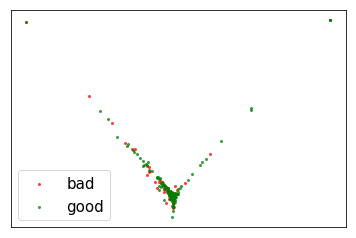

In [28]:
gridsearch_SVM(Xraw, Y, refit_score='f1_score', algo='SVM')

In [29]:
gridsearch_SVM(Xraw, Y, refit_score='f1_score', algo='dummy')


====DummyBaseline (stratified)====
F1 over 10folds:  0.45515205668347775
Accuracy over 10folds:  0.4889566879749509
Cross-validated estimates for data points
              precision    recall  f1-score   support

         bad       0.34      0.31      0.32       213
        good       0.57      0.61      0.59       329

   micro avg       0.49      0.49      0.49       542
   macro avg       0.45      0.46      0.46       542
weighted avg       0.48      0.49      0.48       542

===ConfusionMatrix===
[[ 65 148]
 [129 200]]


In [9]:
print('this is what you call an overfit model: 5000 features for 543 instances!', file=sys.stderr)
print('However, with the sparse vectors like itidf it is more difficult to overfit; .todense() method change the format but not the nature of the vectors')

However, with the sparse vectors like itidf it is more difficult to overfit; .todense() method change the format but not the nature of the vectors


this is what you call an overfit model: 5000 features for 543 instances!
